In [1]:
import os

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [19]:
xy_data_Path = "C:\\Users\\Matth\\OneDrive\\Desktop\\Summer\\Python\\Quadratic_Guesser\\xy_data.csv" #Paths Different for Everyone
xy_data = pd.read_csv(xy_data_Path)

In [20]:
abc_data_Path = "C:\\Users\\Matth\\OneDrive\\Desktop\\Summer\\Python\\Quadratic_Guesser\\abc_data.csv" #Paths Different for Everyone
abc_data = pd.read_csv(abc_data_Path)

In [21]:
all_data=pd.DataFrame.join(xy_data,abc_data)

In [22]:
training_data, validation_data = train_test_split(all_data, test_size=0.2, random_state=42)

In [23]:
X_traine = training_data.iloc[:,0:500]
y_traine = training_data.iloc[:,500:503]

X_vale = validation_data.iloc[:,0:500]
y_vale = validation_data.iloc[:,500:503]

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_traine)
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_traine.to_numpy(), dtype=torch.float32)

X_val_scaled = scaler.transform(X_vale)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_vale.to_numpy(), dtype=torch.float32)

In [25]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

valset = TensorDataset(X_val, y_val)
val_loader = DataLoader(valset, batch_size=64, shuffle=True)

In [26]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 500  # Number of y-coordinates
hidden_size = 128
output_size = 3   # Number of coefficients
model = FeedforwardNN(input_size, hidden_size, output_size).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay = 1e-5)

In [28]:
# Initialize weights
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
model.apply(weights_init)

FeedforwardNN(
  (fc1): Linear(in_features=500, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [29]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    return val_loss / len(val_loader.dataset)

In [30]:
num_epochs = 87
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    
    val_loss = validate_model(model, val_loader, criterion, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}; Val loss = {val_loss}')

Epoch [1/87], Loss: 175.8868; Val loss = 7446.187911157226
Epoch [2/87], Loss: 122.7926; Val loss = 6137.673543249512
Epoch [3/87], Loss: 420.6583; Val loss = 4073.6689635391235
Epoch [4/87], Loss: 3.8019; Val loss = 1623.3784523978711
Epoch [5/87], Loss: 1.0907; Val loss = 650.3345945890427
Epoch [6/87], Loss: 3112.9023; Val loss = 465.1332484639168
Epoch [7/87], Loss: 2.7692; Val loss = 346.6651714521408
Epoch [8/87], Loss: 0.4389; Val loss = 234.94304988179206
Epoch [9/87], Loss: 0.2130; Val loss = 124.81938835924863
Epoch [10/87], Loss: 0.8119; Val loss = 45.95183387461603
Epoch [11/87], Loss: 0.1329; Val loss = 15.947151409864425
Epoch [12/87], Loss: 0.0717; Val loss = 7.595131954212487
Epoch [13/87], Loss: 0.0639; Val loss = 2.617904952133447
Epoch [14/87], Loss: 0.0084; Val loss = 1.71103531550169
Epoch [15/87], Loss: 0.2134; Val loss = 0.7297311518214643
Epoch [16/87], Loss: 0.0140; Val loss = 1.2641941991448402
Epoch [17/87], Loss: 0.0047; Val loss = 1.2230161904048176
Epoch [

In [31]:
import random as rand
def XandYQuadValues(x1,x2,c):
# Calculate 'a' from the y-intercept and x-intercepts
    if x1 * x2 != 0:
        a = c / (x1 * x2)
    else:
        a = 1  # Default to 1 if x1 or x2 is zero to avoid division by zero

    # Define the range of x values to cover the extended plot
    x_min = -50 # Extending beyond the smallest intercept
    x_max = 50  # Extending beyond the largest intercept
    x = np.linspace(x_min, x_max, 500)

    # Calculate the corresponding y values based on the quadratic formula
    y = a * (x - x1) * (x - x2)

    return x,y,a

In [119]:
xydf = pd.DataFrame()
abcdf = pd.DataFrame()
x = pd.DataFrame([list([1,2,3])])

for i in range(0,1):
    x_int1 = rand.uniform(-25,25)
    x_int2 = rand.uniform(-25,25)
    factor = rand.uniform(-25,25)
    x,y,a = XandYQuadValues(x_int1,x_int2,factor)
    xdf = pd.DataFrame([list(x)])
    ydf = pd.DataFrame([list(y)])
    b = a*-(x_int1+x_int2)
    c = a*x_int1*x_int2
    if i == 0:
        xydf = pd.concat([xdf,ydf])
        abcdf = pd.DataFrame([[a, b, c]])
    else:
        xydf = pd.concat([xydf,ydf])
        abcdf = pd.concat([abcdf, pd.DataFrame([list([a, b, c])])])


xydfnp = xydf.iloc[1,:].to_numpy()
xydfnp = np.expand_dims(xydfnp, axis=1)
print(xydfnp.shape)
test_tensor = torch.tensor(xydfnp, dtype=torch.float32)
print(abcdf)

(500, 1)
          0         1         2
0 -0.064593  0.196279  6.145609


In [120]:

model.eval()
with torch.no_grad():  # Turn off gradients since we're in inference mode
    
    test_tensor = test_tensor.view(1, -1)
    test_tensor_scaled = scaler.transform(test_tensor)
    outputs = model(torch.tensor(test_tensor_scaled, dtype=torch.float32))
    
predicted_labels = outputs.detach().numpy()  # Convert to numpy 
print("Predicted Output:", predicted_labels)

Predicted Output: [[-0.06035449  0.21839866  6.128966  ]]


c:\Users\Matth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [67]:
true_values = abcdf.iloc[0,:].to_numpy()
predicted_labels = predicted_labels.flatten()

In [71]:
x = np.linspace(-100, 100, 2000)
y_true = true_values[0]*x**2+true_values[1]*x+true_values[2]
y_predicted = predicted_labels[0]*x**2+predicted_labels[1]*x+predicted_labels[2]

In [ ]:
#per single sample plots

slope, intercept =  np.polyfit(true_values, predicted_labels, 1)
line = slope * true_values + intercept

plt.scatter(true_values, predicted_labels, color='blue', label='Data Points')
plt.plot(true_values, line, color='red', label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('true_values axis')
plt.ylabel('Predicted values')
plt.title('predicted values vs true values')
plt.legend()
plt.show()
print(slope)
print(intercept)
plt.close

plt.plot(x, y_true, label='True Quad')
plt.plot(x, y_predicted, label='True Quad')
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid()
plt.legend()
plt.close

In [198]:
xydf = pd.DataFrame()
abcdf = pd.DataFrame()
x = pd.DataFrame([list([1,2,3])])

num_tests = 10000

for i in range(0,num_tests):
    x_int1 = rand.uniform(-25,25)
    x_int2 = rand.uniform(-25,25)
    factor = rand.uniform(-25,25)
    x,y,a = XandYQuadValues(x_int1,x_int2,factor)
    xdf = pd.DataFrame([list(x)])
    ydf = pd.DataFrame([list(y)])
    b = a*-(x_int1+x_int2)
    c = a*x_int1*x_int2
    if i == 0:
        xydf = pd.concat([xdf,ydf])
        abcdf = pd.DataFrame([[a, b, c]])
    else:
        xydf = pd.concat([xydf,ydf])
        abcdf = pd.concat([abcdf, pd.DataFrame([list([a, b, c])])])


In [ ]:
a_real, a_guess,b_real, b_guess, c_real, c_guess = [], [], [], [], [], []


for i in range(0,num_tests):


    xydfnpslice = xydf.iloc[i+1,:].to_numpy()
    xydfnpslice = np.expand_dims(xydfnpslice, axis=1)
    test_tensor_slice = torch.tensor(xydfnpslice, dtype=torch.float32)

    model.eval()
    with torch.no_grad():  # Turn off gradients since we're in inference mode
    
        test_tensor_slice = test_tensor_slice.view(1, -1)
        test_tensor_slice_scaled = scaler.transform(test_tensor_slice)
        outputs = model(torch.tensor(test_tensor_slice_scaled, dtype=torch.float32))
        predicted_labels = outputs.detach().numpy()  # Convert to numpy 
    
    a_real.append(abcdf.iloc[i,:].to_numpy().flatten()[0])
    a_guess.append(predicted_labels.flatten()[0])
    b_real.append(abcdf.iloc[i,:].to_numpy().flatten()[1])
    b_guess.append(predicted_labels.flatten()[1])
    c_real.append(abcdf.iloc[i,:].to_numpy().flatten()[2])
    c_guess.append(predicted_labels.flatten()[2])   

#THIS SPEWS A BUNCH OF ERRORS BUT DON'T WORRY ABOUT IT

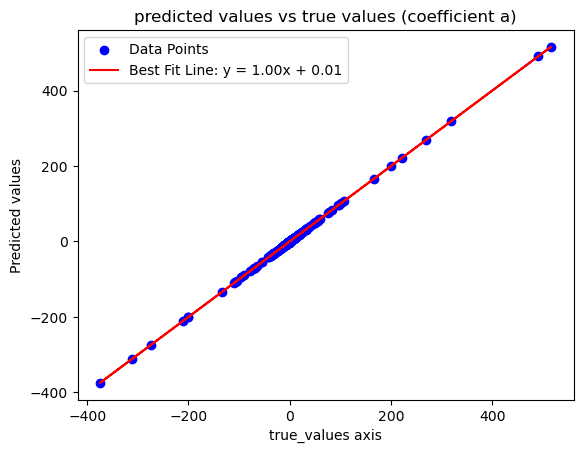

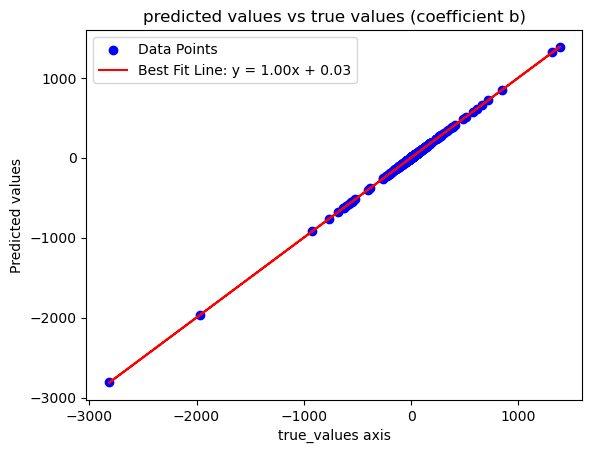

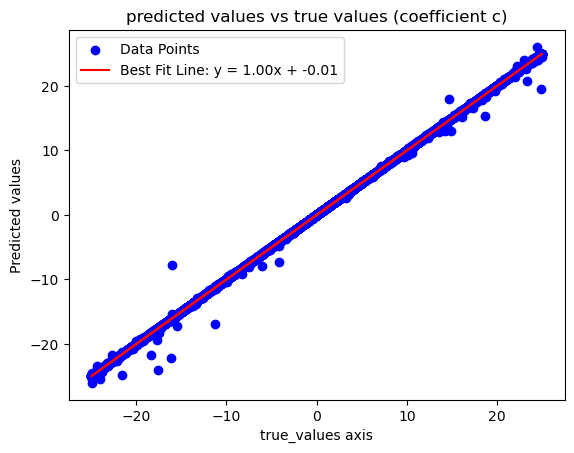

In [200]:
def plotabc(real, guess, name):
    slope, intercept =  np.polyfit(real, guess, 1)
    line = slope * np.array(real) + intercept
    plt.scatter(real, guess, color='blue', label='Data Points')
    plt.plot(real, line, color='red', label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('true_values axis')
    plt.ylabel('Predicted values')
    plt.title(f'predicted values vs true values (coefficient {name})')
    plt.legend()
    plt.show()
    # print(slope)
    # print(intercept)
    plt.close

plotabc(a_real, a_guess, 'a')
plotabc(b_real, b_guess, 'b')
plotabc(c_real, c_guess, 'c')